## **Data Import**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve
)

# Import Census Income dataset from UCI website
cols = ["age", "workclass", "fnlwgt", "education", "education-num",
        "marital-status", "occupation", "relationship", "race", "sex",
        "capital-gain", "capital-loss", "hours-per-week", "native-country",
        "income"]

train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
train_df = pd.read_csv(train_url, header=None, names=cols)

test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
test_df = pd.read_csv(test_url, header=None, names=cols, skiprows=1)

Concatenating the training and test sets so that data cleaning and EDA can be done simultaneously for both datasets.

In [2]:
# Assign flags to training and test records for future reverse concatenation
train_df["is-train"] = 1
test_df["is-train"] = 0
full_data_df = pd.concat([train_df, test_df], ignore_index=True)
print("Training Data Shape: ", train_df.shape)
print("Test Data Shape: ", test_df.shape)
print("Concatenated Data Shape: ", full_data_df.shape)

Training Data Shape:  (32561, 16)
Test Data Shape:  (16281, 16)
Concatenated Data Shape:  (48842, 16)


## **Missing Values Handling**

Missing values indicated as "?" in the original dataset are first replaced with "NaN".

The number and percentage of missing values under each attribute are calculated.

In [3]:
full_data_df = full_data_df.replace(" ?", np.nan)
print("Reviewing number of missing values and their % proportion within each attribute column")
for attr in full_data_df.columns:
  missingNum_per_col = full_data_df[attr].isnull().sum()
  missingPercent_per_col = (missingNum_per_col / len(full_data_df)) * 100
  print(f"{attr}: {missingNum_per_col};{missingPercent_per_col: .2f}%")

Reviewing number of missing values and their % proportion within each attribute column
age: 0; 0.00%
workclass: 2799; 5.73%
fnlwgt: 0; 0.00%
education: 0; 0.00%
education-num: 0; 0.00%
marital-status: 0; 0.00%
occupation: 2809; 5.75%
relationship: 0; 0.00%
race: 0; 0.00%
sex: 0; 0.00%
capital-gain: 0; 0.00%
capital-loss: 0; 0.00%
hours-per-week: 0; 0.00%
native-country: 857; 1.75%
income: 0; 0.00%
is-train: 0; 0.00%


The percentages of missing values are relatively small when compared to the large dataset.

Since we are cleaning the training and test sets together, and it would be unreasonable to remove data records with missing values from the test set, we will proceed with mode imputation.

In [4]:
# Impute Missing Values
from sklearn.impute import SimpleImputer
full_data_df_cleaned = full_data_df.copy()
imputer = SimpleImputer(strategy="most_frequent")
full_data_df_cleaned[["workclass", "occupation", "native-country"]] = imputer.fit_transform(
    full_data_df_cleaned[["workclass", "occupation", "native-country"]])
print("Concatenated Data Shape (Imputed): ", full_data_df_cleaned.shape)

Concatenated Data Shape (Imputed):  (48842, 16)


## **Removing Duplicates**

In [5]:
print("Number of duplicated rows: ", full_data_df_cleaned.duplicated().sum())
full_data_df_cleaned = full_data_df_cleaned.drop_duplicates()
print("Concatenated Data Shape (Duplicates Removed): ", full_data_df_cleaned.shape)

Number of duplicated rows:  29
Concatenated Data Shape (Duplicates Removed):  (48813, 16)


## **Exploratory Data Analysis (EDA)**

### Target Class ("<=50K", ">50K") Distribution

income
<=50K     24698
<=50K.    12430
>50K       7839
>50K.      3846
Name: count, dtype: int64
--------------------------


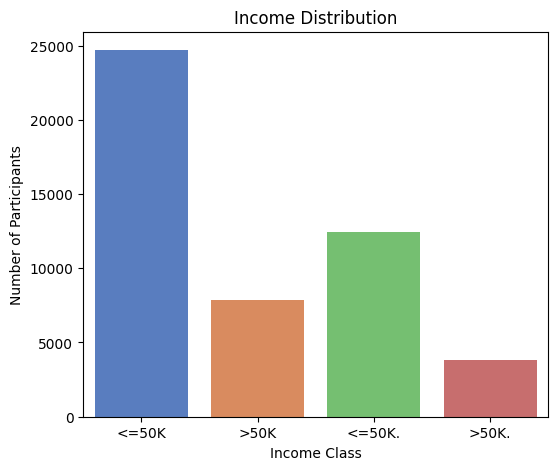

In [6]:
# Remove whitespace
full_data_df_cleaned["income"] = full_data_df_cleaned["income"].str.strip()

# Count and visualise how many records in each target class
print(full_data_df_cleaned["income"].value_counts())
print("--------------------------")
plt.figure(figsize=(6,5))
sns.countplot(data=full_data_df_cleaned, x="income", hue="income", palette="muted")
plt.title("Income Distribution")
plt.xlabel("Income Class")
plt.ylabel("Number of Participants")
plt.show()

It remains clear from the analysis that the dataset contains only two valid target classes, <=50K and >50K. However, certain entries are inconsistently labelled with an extra "." character.

Therefore, we need to standardise the class labellings.

income
<=50K    37128
>50K     11685
Name: count, dtype: int64
--------------------------


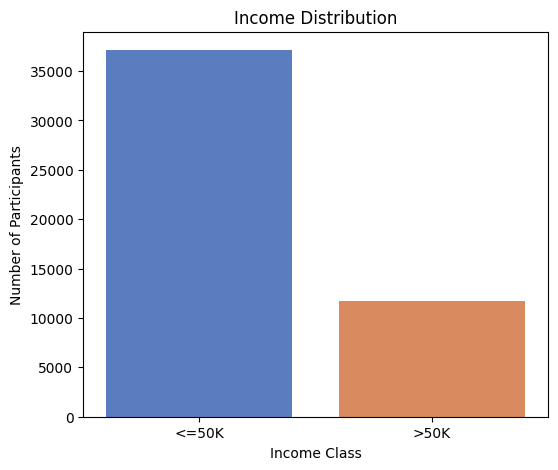

In [7]:
full_data_df_cleaned["income"] = full_data_df_cleaned["income"].replace(
    {"<=50K." : "<=50K",
     ">50K." : ">50K"})

# Count and visualise again
print(full_data_df_cleaned["income"].value_counts())
print("--------------------------")
plt.figure(figsize=(6,5))
sns.countplot(data=full_data_df_cleaned, x="income", hue="income", palette="muted")
plt.title("Income Distribution")
plt.xlabel("Income Class")
plt.ylabel("Number of Participants")
plt.show()

**Findings:**
*  The dataset is imbalanced and skewed, with majority of the census participants earning an income of 50K or less.



### Age

Minimum Age:  17
Maximum Age:  90
--------------------------


<Axes: xlabel='age', ylabel='Count'>

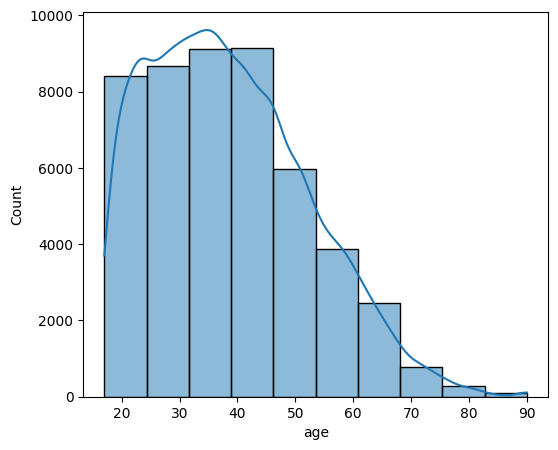

In [8]:
print("Minimum Age: ", min(full_data_df_cleaned.age.values))
print("Maximum Age: ", max(full_data_df_cleaned.age.values))
print("--------------------------")
plt.figure(figsize=(6,5))
sns.histplot(full_data_df_cleaned["age"], bins=10, kde=True)

The age distribution is heavily skewed, hence we can choose to normalise it later when building the classifications model.

Let's bin the "age" values into different age groups to help us in interpreting the relationship between age distribution and income.

age-group
30s    12834
20s    12158
40s    10397
50s     6202
10s     3617
60s     2738
70s      720
80s      147
Name: count, dtype: int64
--------------------------


<Axes: xlabel='age-group', ylabel='Count'>

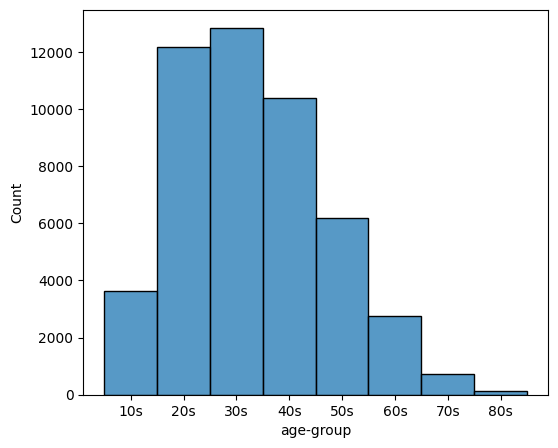

In [9]:
# Discretisation/Binning of "age" attribute for better visualisation
# 14 is the minimum working age in the US
bins = [14, 20, 30, 40, 50, 60, 70, 80, 90]
labels = ["10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s"]
full_data_df_cleaned["age-group"] = pd.cut(full_data_df_cleaned["age"], bins=bins, labels=labels)
print(full_data_df_cleaned["age-group"].value_counts())
print("--------------------------")
plt.figure(figsize=(6,5))
sns.histplot(full_data_df_cleaned["age-group"])

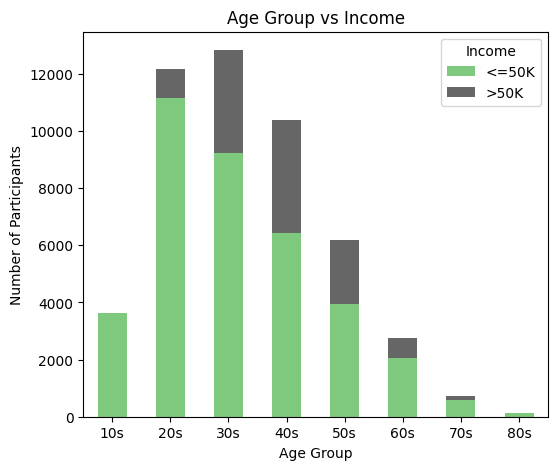

In [10]:
# Assessing Age Group VS Income
agegroup_income = pd.crosstab(full_data_df_cleaned["age-group"], full_data_df_cleaned["income"])
agegroup_income.plot(kind="bar", stacked=True, figsize=(6,5), colormap="Accent")
plt.xlabel("Age Group")
plt.ylabel("Number of Participants")
plt.title("Age Group vs Income")
plt.legend(title="Income")
plt.xticks(rotation=0)
plt.show()

**Findings:**
*   Overall, the majority of participants across all age groups continue to earn 50k or less.
*   Participants in their 30s and 40s representing the mid-career workforce, are most likely to earn an income exceeding 50k.
*   Participants in their 60s, 70s, and 80s continue to earn income, though their numbers are comparatively smaller than other age groups. Additionally, this age group represents only a small fraction of the overall dataset.



### Workclass

In [11]:
print("Before aggregation: ")
print(full_data_df_cleaned["workclass"].value_counts())

Before aggregation: 
workclass
Private             36678
Self-emp-not-inc     3861
Local-gov            3136
State-gov            1981
Self-emp-inc         1694
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64


**Record-level manipulation via aggregation:**
*  "Self-emp-not-inc" and "Self-emp-inc" are replaced with "Self-Employed"
*  "Local-gov", "State-gov" and "Federal-gov" are replaced with "Government-Employed"

In [12]:
full_data_df_cleaned["workclass"] = full_data_df_cleaned["workclass"].str.strip()
def merge_workclass(val):
    if val in ["Self-emp-not-inc", "Self-emp-inc"]:
      return "Self-Employed"
    elif val in ["Local-gov", "State-gov", "Federal-gov"]:
      return "Government-Employed"
    else:
      return val
full_data_df_cleaned["workclass"] = full_data_df_cleaned["workclass"].apply(merge_workclass)

print("After aggregation: ")
print(full_data_df_cleaned["workclass"].value_counts())

After aggregation: 
workclass
Private                36678
Government-Employed     6549
Self-Employed           5555
Without-pay               21
Never-worked              10
Name: count, dtype: int64


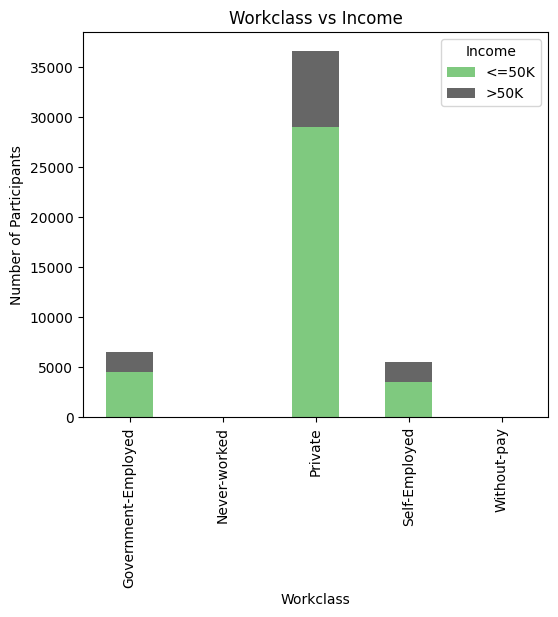

In [13]:
# Visualise the new distribution
workclass_income = pd.crosstab(full_data_df_cleaned["workclass"], full_data_df_cleaned["income"])
workclass_income.plot(kind="bar", stacked=True, figsize=(6,5), colormap="Accent")
plt.xlabel("Workclass")
plt.ylabel("Number of Participants")
plt.title("Workclass vs Income")
plt.legend(title="Income")
plt.xticks(rotation=90)
plt.show()

**Findings:**
*   Most participants in this census have worked in the private sector, thus resulting in the highest counts as compared to the other sectors.
*   Self-employed and government-employed individuals seem to have a similar likelihood of earning more than 50k.
*   There are very few individuals without pay or have never worked before, hence these categories might not add much predictive power. They will still be retained to ensure that the dataset is not oversimplied.



### fnlwgt

count    4.881300e+04
mean     1.896679e+05
std      1.056062e+05
min      1.228500e+04
25%      1.175550e+05
50%      1.781400e+05
75%      2.376200e+05
max      1.490400e+06
Name: fnlwgt, dtype: float64
--------------------------


<Axes: xlabel='fnlwgt', ylabel='Count'>

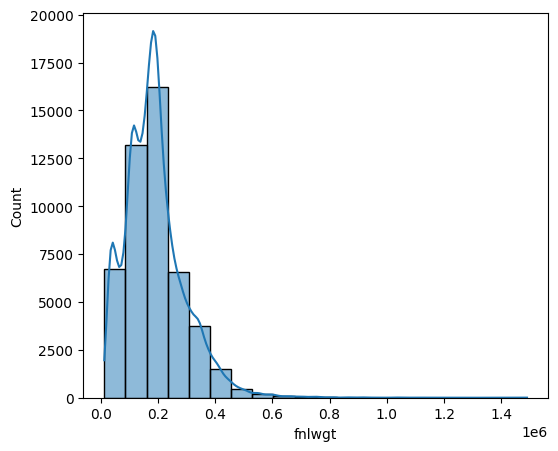

In [14]:
print(full_data_df_cleaned["fnlwgt"].describe())
print("--------------------------")
plt.figure(figsize=(6,5))
sns.histplot(full_data_df_cleaned["fnlwgt"], bins=20, kde=True)

The variation of "fnlwgt" is quite large according to the data description. Moreover, it does not seem to be a meaningful predictive attribute for our model, hence "fnlwgt" will be dropped.

In [15]:
full_data_df_cleaned = full_data_df_cleaned.drop(columns=["fnlwgt"])

### Education, Education-Num

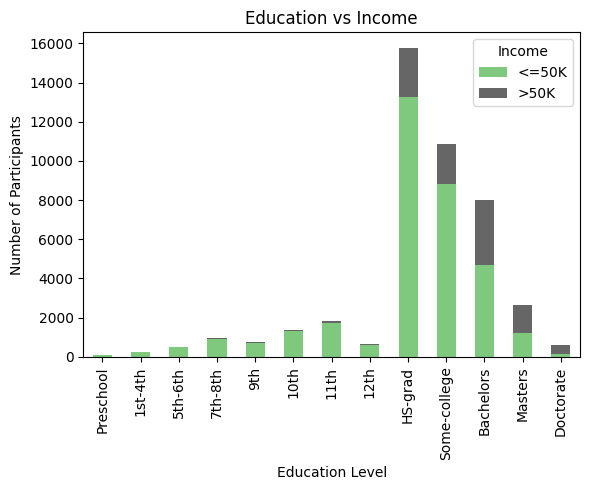

In [16]:
# Assessing Education VS Income
full_data_df_cleaned["education"] = full_data_df_cleaned["education"].str.strip()

order = ["Preschool", "1st-4th", "5th-6th", "7th-8th",
         "9th", "10th", "11th", "12th",
         "HS-grad", "Some-college", "Bachelors", "Masters", "Doctorate"]
edu_income = pd.crosstab(full_data_df_cleaned["education"], full_data_df_cleaned["income"])
edu_income = edu_income.reindex(order)
edu_income.plot(kind="bar", stacked=True, figsize=(6,5), colormap="Accent")
plt.title("Education vs Income")
plt.xlabel("Education Level")
plt.ylabel("Number of Participants")
plt.xticks(rotation=90)
plt.legend(title="Income")
plt.tight_layout()
plt.show()

In [17]:
edu_mapping = full_data_df_cleaned.groupby(["education", "education-num"]).size().reset_index(name="number of participants")
edu_mapping = edu_mapping.sort_values("education-num").reset_index(drop=True)
print(edu_mapping)

       education  education-num  number of participants
0      Preschool              1                      82
1        1st-4th              2                     245
2        5th-6th              3                     508
3        7th-8th              4                     954
4            9th              5                     756
5           10th              6                    1389
6           11th              7                    1812
7           12th              8                     656
8        HS-grad              9                   15777
9   Some-college             10                   10869
10     Assoc-voc             11                    2060
11    Assoc-acdm             12                    1601
12     Bachelors             13                    8020
13       Masters             14                    2656
14   Prof-school             15                     834
15     Doctorate             16                     594


We can observed that each value for "education" corresponds to a value in "education-num", indicating that the "education" attribute is already encoded. Therefore, the "education" attribute can be dropped.

In [18]:
full_data_df_cleaned = full_data_df_cleaned.drop(columns=["education"])

**Findings**
*   Majority of the income earning participants belong to the "HS-grad" category, most likely due to its relatively large number of records present within the dataset.
*   The probability of earning more than 50K is greater for individuals with higher levels of education, with the "Bachelors" category recording the greatest number of census participants with >50K.



### Marital-Status

In [19]:
print("Before aggregation: ")
print(full_data_df_cleaned["marital-status"].value_counts())

Before aggregation: 
marital-status
Married-civ-spouse       22372
Never-married            16098
Divorced                  6630
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: count, dtype: int64


**Record-level manipulation via aggregation:**
*  "Married-civ-spouse" and "Married-AF-spouse" are replaced with "Married-pubservices-spouse"

In [20]:
full_data_df_cleaned["marital-status"] = full_data_df_cleaned["marital-status"].str.strip()
def merge_maritalstatus(val):
    if val in ["Married-civ-spouse", "Married-AF-spouse"]:
      return "Married-pubserv-spouse"
    else:
      return val
full_data_df_cleaned["marital-status"] = full_data_df_cleaned["marital-status"].apply(merge_maritalstatus)
print("After aggregation: ")
print(full_data_df_cleaned["marital-status"].value_counts())

After aggregation: 
marital-status
Married-pubserv-spouse    22409
Never-married             16098
Divorced                   6630
Separated                  1530
Widowed                    1518
Married-spouse-absent       628
Name: count, dtype: int64


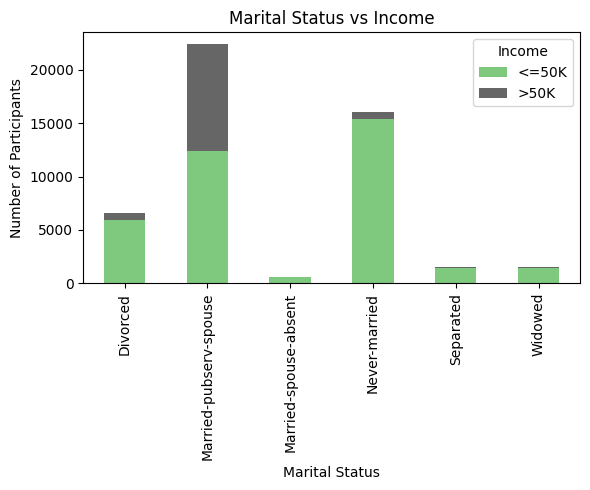

In [21]:
# Assessing Marital Status VS Income
marital_income = pd.crosstab(full_data_df_cleaned["marital-status"], full_data_df_cleaned["income"])
marital_income.plot(kind="bar", stacked=True, figsize=(6,5), colormap="Accent")
plt.title("Marital Status vs Income")
plt.xlabel("Marital Status")
plt.ylabel("Number of Participants")
plt.xticks(rotation=90)
plt.legend(title="Income")
plt.tight_layout()
plt.show()

**Findings**
*   Individual with spouses working in public services (i.e. civilian and armed forces) are most likely to earn more than 50K.
*   There seems to be no records of individuals with absent spouses earning more than 50K.



### Occupation

occupation
Prof-specialty       8976
Craft-repair         6107
Exec-managerial      6084
Adm-clerical         5608
Sales                5504
Other-service        4919
Machine-op-inspct    3019
Transport-moving     2355
Handlers-cleaners    2071
Farming-fishing      1487
Tech-support         1445
Protective-serv       983
Priv-house-serv       240
Armed-Forces           15
Name: count, dtype: int64
--------------------------


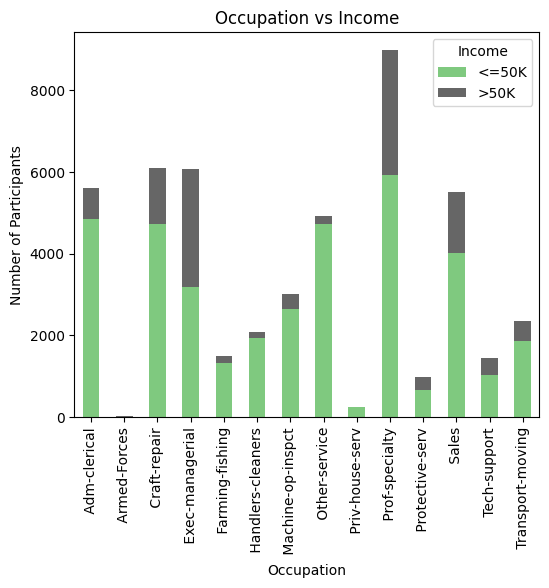

In [22]:
print(full_data_df_cleaned["occupation"].value_counts())
print("--------------------------")

# Assessing Occupation VS Income
occupation_income = pd.crosstab(full_data_df_cleaned["occupation"], full_data_df_cleaned["income"])
occupation_income.plot(kind="bar", stacked=True, figsize=(6,5), colormap="Accent")
plt.xlabel("Occupation")
plt.ylabel("Number of Participants")
plt.title("Occupation vs Income")
plt.legend(title="Income")
plt.xticks(rotation = 90)
plt.show()

**Findings**
*   Majority of the data entries came from individuals with professional specialty.
*   It seems that participants in Professional and Executive Managerial roles have the highest likelihood of earning more than 50K.
*   Conversely, individuals who are Handler Cleaners, or are working in the Farming-Fishing and Other Service industries have lower probabilities of earning an income exceeding 50K.

### Relationship

relationship
Husband           19709
Not-in-family     12567
Own-child          7576
Unmarried          5124
Wife               2331
Other-relative     1506
Name: count, dtype: int64
--------------------------


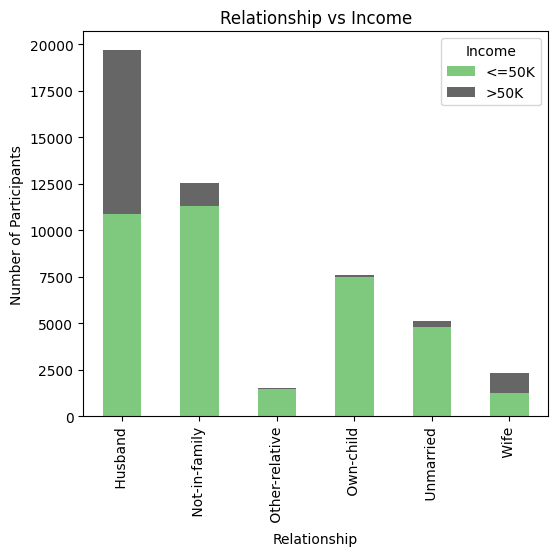

In [23]:
print(full_data_df_cleaned["relationship"].value_counts())
print("--------------------------")

# Assessing Relationship VS Income
relationship_income = pd.crosstab(full_data_df_cleaned["relationship"], full_data_df_cleaned["income"])
relationship_income.plot(kind="bar", stacked=True, figsize=(6,5), colormap="Accent")
plt.xlabel("Relationship")
plt.ylabel("Number of Participants")
plt.title("Relationship vs Income")
plt.legend(title="Income")
plt.xticks(rotation=90)
plt.show()

**Findings**
*   Overall, the majority of participants across all relationship categories continue to earn 50K or less.
*   Among all categories, husbands are most likely to earn more than 50K.
*   By comparing the lengths of the >50K bars for the Wife and Not-in-Family categories, it appears that the proportion of individuals earning above 50K is roughly the same.

### Race

race
White                 41736
Black                  4683
Asian-Pac-Islander     1518
Amer-Indian-Eskimo      470
Other                   406
Name: count, dtype: int64
--------------------------


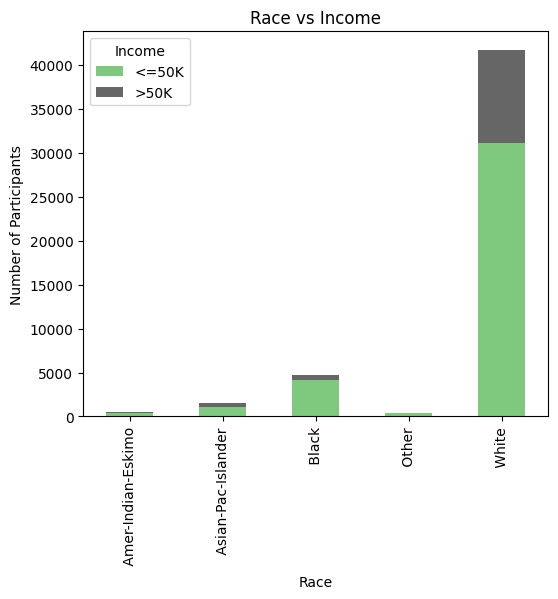

In [24]:
print(full_data_df_cleaned["race"].value_counts())
print("--------------------------")

# Assessing Race VS Income
race_income = pd.crosstab(full_data_df_cleaned["race"], full_data_df_cleaned["income"])
race_income.plot(kind="bar", stacked=True, figsize=(6,5), colormap="Accent")
plt.xlabel("Race")
plt.ylabel("Number of Participants")
plt.title("Race vs Income")
plt.legend(title="Income")
plt.xticks(rotation=90)
plt.show()

**Findings**
*   The Race attribute values are highly imbalanced, with majority of the census participants being White.

### Gender (Sex)

sex
Male      32631
Female    16182
Name: count, dtype: int64
--------------------------


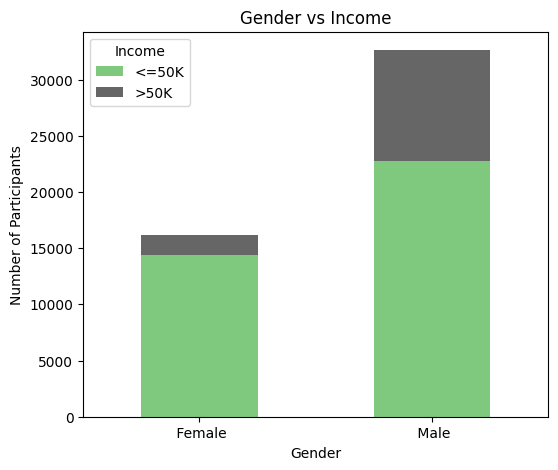

In [25]:
print(full_data_df_cleaned["sex"].value_counts())
print("--------------------------")

# Assessing Gender VS Income
gender_income = pd.crosstab(full_data_df_cleaned["sex"], full_data_df_cleaned["income"])
gender_income.plot(kind="bar", stacked=True, figsize=(6,5), colormap="Accent")
plt.xlabel("Gender")
plt.ylabel("Number of Participants")
plt.title("Gender vs Income")
plt.legend(title="Income")
plt.xticks(rotation=0)
plt.show()

**Findings**
*   Majority of the census participants are males.
*   It also appears that males are more likely to earn above 50K than females, as highlighted by the length of the 50K bar.

### Capital-Gain, Capital-Loss

capital-gain
0        44778
15024      513
7688       410
7298       364
99999      244
         ...  
1639         1
2387         1
7262         1
1731         1
6612         1
Name: count, Length: 123, dtype: int64


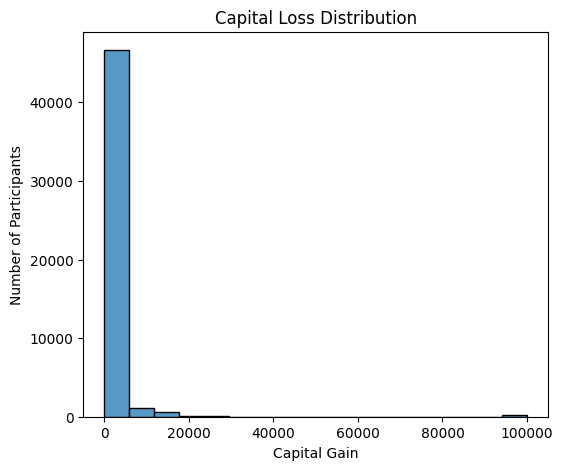

-----------------------------------------------------------
capital-loss
0       46531
1902      304
1977      253
1887      233
2415       72
        ...  
2201        1
1870        1
1911        1
2465        1
1421        1
Name: count, Length: 99, dtype: int64


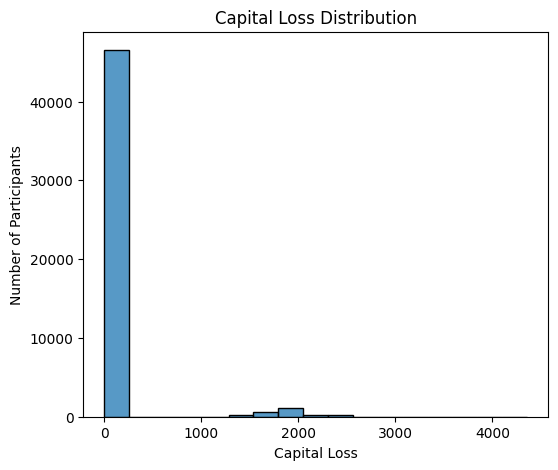

In [26]:
print(full_data_df_cleaned["capital-gain"].value_counts())
plt.figure(figsize=(6,5))
sns.histplot(full_data_df_cleaned["capital-gain"])
plt.xlabel("Capital Gain")
plt.ylabel("Number of Participants")
plt.title("Capital Loss Distribution")
plt.show()

print("-----------------------------------------------------------")

print(full_data_df_cleaned["capital-loss"].value_counts())
plt.figure(figsize=(6,5))
sns.histplot(full_data_df_cleaned["capital-loss"])
plt.xlabel("Capital Loss")
plt.ylabel("Number of Participants")
plt.title("Capital Loss Distribution")
plt.show()

A large proportion of the capital-gain and capital-loss values appear to be zeros, thereby indicating their lack of predictive power in training our model. Hence, we will choose to drop these columns.

In [27]:
full_data_df_cleaned = full_data_df_cleaned.drop(columns=["capital-gain", "capital-loss"])

### Hours-Per-Week

Minimum Hours Per Week:  1
Maximum Hours Per Week:  99
--------------------------
hours-per-week
40    22787
50     4244
45     2716
60     2177
35     1935
      ...  
87        1
82        1
94        1
79        1
69        1
Name: count, Length: 96, dtype: int64
--------------------------


<Axes: xlabel='hours-per-week', ylabel='Count'>

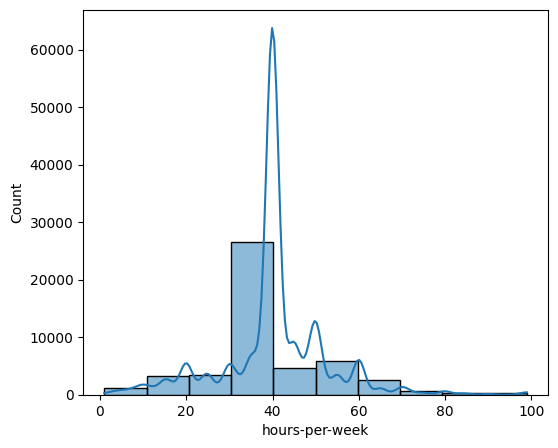

In [28]:
print("Minimum Hours Per Week: ", min(full_data_df_cleaned["hours-per-week"].values))
print("Maximum Hours Per Week: ", max(full_data_df_cleaned["hours-per-week"].values))
print("--------------------------")
print(full_data_df_cleaned["hours-per-week"].value_counts())
print("--------------------------")
plt.figure(figsize=(6,5))
sns.histplot(full_data_df_cleaned["hours-per-week"], bins=10, kde=True)

weekly-workhours-group
Full-time    30018
Overtime     12671
Part-time     4448
Extreme       1676
Name: count, dtype: int64
--------------------------


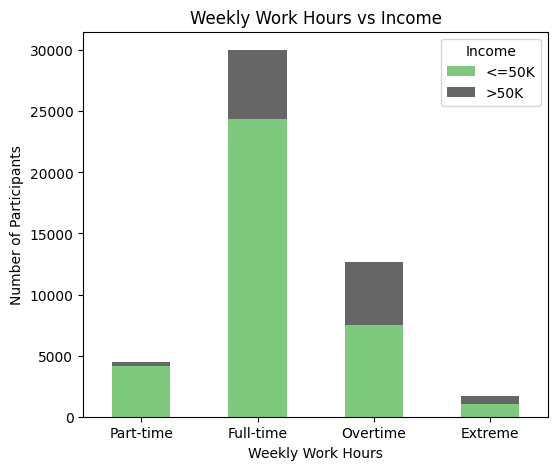

In [29]:
# Grouping of "hours-per-week" attribute into different categories for better visualisation
bins = [0, 20, 40, 60, 100]
labels = ["Part-time", "Full-time", "Overtime", "Extreme"]
full_data_df_cleaned["weekly-workhours-group"] = pd.cut(full_data_df_cleaned["hours-per-week"], bins=bins, labels=labels)
print(full_data_df_cleaned["weekly-workhours-group"].value_counts())
print("--------------------------")

# Assessing Weekly Working Hour Group VS Income
weeklyworkhour_income = pd.crosstab(full_data_df_cleaned["weekly-workhours-group"], full_data_df_cleaned["income"])
weeklyworkhour_income.plot(kind="bar", stacked=True, figsize=(6,5), colormap="Accent")
plt.xlabel("Weekly Work Hours")
plt.ylabel("Number of Participants")
plt.title("Weekly Work Hours vs Income")
plt.legend(title="Income")
plt.xticks(rotation=0)
plt.show()

**Findings**
*   As highlighted above, a great number of census participants who were mostly adults worked 40 hours a week, which is equivalent to the usual 8 hours per day of a full-time worker.
*   The >50K bar lengths for both the full-time and overtime groups suggest that a similar proportion of individuals in these categories earn more than 50K.



### Native-Country

In [30]:
print("Unique values in Native-Country attribute: ", full_data_df_cleaned["native-country"].unique())

Unique values in Native-Country attribute:  [' United-States' ' Cuba' ' Jamaica' ' India' ' Mexico' ' South'
 ' Puerto-Rico' ' Honduras' ' England' ' Canada' ' Germany' ' Iran'
 ' Philippines' ' Italy' ' Poland' ' Columbia' ' Cambodia' ' Thailand'
 ' Ecuador' ' Laos' ' Taiwan' ' Haiti' ' Portugal' ' Dominican-Republic'
 ' El-Salvador' ' France' ' Guatemala' ' China' ' Japan' ' Yugoslavia'
 ' Peru' ' Outlying-US(Guam-USVI-etc)' ' Scotland' ' Trinadad&Tobago'
 ' Greece' ' Nicaragua' ' Vietnam' ' Hong' ' Ireland' ' Hungary'
 ' Holand-Netherlands']


In [31]:
print(full_data_df_cleaned["native-country"].value_counts())

native-country
United-States                 44666
Mexico                          947
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Poland                           87
Vietnam                          86
Guatemala                        86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru                             46
Ecuador      

**Record-level manipulation** by grouping the countries above into different regions to reduce the complexity of the training dataset and improve the model's generalisation.

In [32]:
full_data_df_cleaned["native-country"] = full_data_df_cleaned["native-country"].str.strip()
def merge_nativecountry(val):
    if val in ["United-States", "Canada", "Mexico", "Outlying-US(Guam-USVI-etc)",
               "Puerto-Rico"]:
      return "North America"
    elif val in ["Cuba", "Jamaica", "Honduras", "Columbia", "Dominican-Republic",
                 "El-Salvador", "Guatemala", "Haiti", "Nicaragua", "Trinadad&Tobago",
                 "Ecuador", "Peru"]:
      return "Central/South America"
    elif val in ["England", "Germany", "Poland", "Portugal", "France", "Italy",
                 "Yugoslavia", "Scotland", "Greece", "Ireland", "Hungary",
                 "Holand-Netherlands"]:
      return "Europe"
    elif val in ["India", "Iran", "Philippines", "Cambodia", "Thailand", "Laos",
                 "Taiwan", "China", "Japan", "Vietnam", "Hong",
                 "South"]:
      return "Asia"
    else:
      return val
full_data_df_cleaned["native-country"] = full_data_df_cleaned["native-country"].apply(merge_nativecountry)
full_data_df_cleaned.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,is-train,age-group,weekly-workhours-group
0,39,Government-Employed,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,North America,<=50K,1,30s,Full-time
1,50,Self-Employed,13,Married-pubserv-spouse,Exec-managerial,Husband,White,Male,13,North America,<=50K,1,40s,Part-time
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,North America,<=50K,1,30s,Full-time
3,53,Private,7,Married-pubserv-spouse,Handlers-cleaners,Husband,Black,Male,40,North America,<=50K,1,50s,Full-time
4,28,Private,13,Married-pubserv-spouse,Prof-specialty,Wife,Black,Female,40,Central/South America,<=50K,1,20s,Full-time


native-country
North America            46002
Asia                      1096
Central/South America      935
Europe                     780
Name: count, dtype: int64
--------------------------
After grouping: 


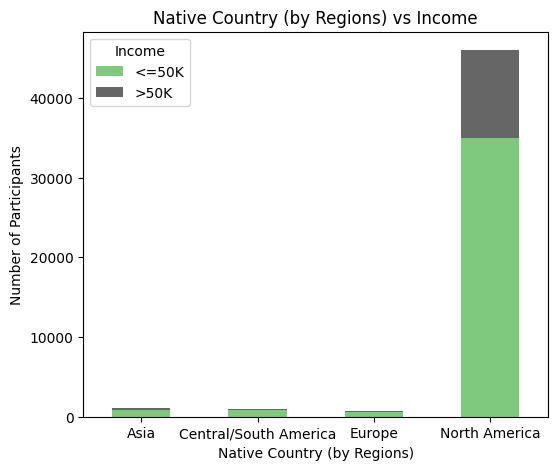

In [33]:
# Assessing Native Country VS Income
print(full_data_df_cleaned["native-country"].value_counts())
print("--------------------------")
print("After grouping: ")
nativecountry_income = pd.crosstab(full_data_df_cleaned["native-country"], full_data_df_cleaned["income"])
nativecountry_income.plot(kind="bar", stacked=True, figsize=(6,5), colormap="Accent")
plt.xlabel("Native Country (by Regions)")
plt.ylabel("Number of Participants")
plt.title("Native Country (by Regions) vs Income")
plt.legend(title="Income")
plt.xticks(rotation=0)
plt.show()

**Findings**
*  We can observe that the dataset is highly imbalanced, with almost 90% of the data entries having "United States" as their native-country.
*  Without grouping them into regions, countries with very few records may add noise to the trained model.

## **Model Setup**

In [34]:
for attr in full_data_df_cleaned.select_dtypes(include="object").columns:
    full_data_df_cleaned[attr] = full_data_df_cleaned[attr].astype("category")

full_data_df_cleaned.dtypes

age                          int64
workclass                 category
education-num                int64
marital-status            category
occupation                category
relationship              category
race                      category
sex                       category
hours-per-week               int64
native-country            category
income                    category
is-train                     int64
age-group                 category
weekly-workhours-group    category
dtype: object

In [35]:
train_df_cleaned = full_data_df_cleaned[full_data_df_cleaned["is-train"] == 1].drop(columns=["is-train"])
print("Final Training Set Shape: ", train_df_cleaned.shape)

test_df_cleaned = full_data_df_cleaned[full_data_df_cleaned["is-train"] == 0].drop(columns=["is-train"])
print("Final Test Set Shape: ", test_df_cleaned.shape)

Final Training Set Shape:  (32537, 13)
Final Test Set Shape:  (16276, 13)


### Split into training and test sets

In [36]:
model_train_df = train_df_cleaned.copy()
model_train_df = model_train_df.drop(columns=["age-group", "weekly-workhours-group"])
model_Xtrain = model_train_df.drop("income", axis=1)
model_Ytrain = model_train_df["income"]

model_test_df = test_df_cleaned.copy()
model_test_df = model_test_df.drop(columns=["age-group", "weekly-workhours-group"])
model_Xtest = model_test_df.drop("income", axis=1)
model_Ytest = model_test_df["income"]

### Final round of preprocessing

In [37]:
numeric_attr = model_Xtrain.select_dtypes(include=["int64"]).columns
categorical_attr = model_Xtrain.select_dtypes(include=["category"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num_attr", StandardScaler(), numeric_attr),
        ("cat_attr", OneHotEncoder(handle_unknown="ignore"), categorical_attr)
    ])

### Creating the Logistic Regression training pipeline

In [ ]:
logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=5000))
])

logreg_param_dist = {
    "classifier__penalty": ["l1", "l2"],
    "classifier__C": [0.1, 1, 10],
    "classifier__solver": ["saga"]
}

scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, pos_label=">50K"),
    "recall": make_scorer(recall_score, pos_label=">50K"),
    "f1": make_scorer(f1_score, pos_label=">50K"),
}

logreg_search = RandomizedSearchCV(
    logreg_pipeline,
    param_distributions=logreg_param_dist,
    n_iter=10,
    cv=5,
    random_state=42,
    scoring=scoring,
    refit="f1"
)

### Creating the Random Forest Classifier training pipeline

In [ ]:
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

rf_param_dist = {
    "classifier__n_estimators": [100, 200, 500],
    "classifier__max_depth": [5, 10, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 5],
}

scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, pos_label=">50K"),
    "recall": make_scorer(recall_score, pos_label=">50K"),
    "f1": make_scorer(f1_score, pos_label=">50K"),
}

rf_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_dist,
    n_iter=10,
    cv=5,
    random_state=42,
    scoring=scoring,
    refit="f1"
)

### Define the model evaluation function

In [40]:
def evaluate_model(model, x_train, y_train, x_test, y_test, model_name="Model"):
    results = {}

    # Training Time
    start_traintime = time.time()
    model.fit(x_train, y_train)
    end_traintime = time.time()
    train_time = end_traintime - start_traintime

    # Prediction Time
    start_predtime = time.time()
    y_pred = model.predict(x_test)
    end_predtime = time.time()
    pred_time = end_predtime - start_predtime

    # Probabilities for ROC/PR
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(x_test)[:, 1]
    else:
        y_prob = model.decision_function(x_test)


    print(f"\n🔍 {model_name} Hyperparameter Tuning Results:")
    print("Best Parameters:", model.best_params_)
    print(f"Best CV Score: {model.best_score_: .4f}")

    # Evaluation Metrics
    results["Accuracy"] = accuracy_score(y_test, y_pred)
    results["Precision"] = precision_score(y_test, y_pred, pos_label=">50K")
    results["Recall"] = recall_score(y_test, y_pred, pos_label=">50K")
    results["F1 Score"] = f1_score(y_test, y_pred, pos_label=">50K")
    results["Training Time"] = train_time
    results["Prediction Time"] = pred_time

    print(f"\n {model_name} Model Evaluation:")
    print(classification_report(y_test, y_pred))
    for k, v in results.items():
        print(f"{k}: {v:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=["<=50K", ">50K"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<=50K", ">50K"])
    disp.plot(cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    return results, y_test, y_prob

### Evaluating the performance of the Logistic Regression model

C:\Users\Wenni\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



🔍 Logistic Regression Hyperparameter Tuning Results:
Best Parameters: {'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 1}
Best CV Score:  0.6095

 Logistic Regression Model Evaluation:
              precision    recall  f1-score   support

       <=50K       0.87      0.92      0.89     12430
        >50K       0.68      0.55      0.61      3846

    accuracy                           0.83     16276
   macro avg       0.77      0.73      0.75     16276
weighted avg       0.82      0.83      0.83     16276

Accuracy: 0.8321
Precision: 0.6806
Recall: 0.5458
F1 Score: 0.6058
Training Time: 601.2196
Prediction Time: 0.0568


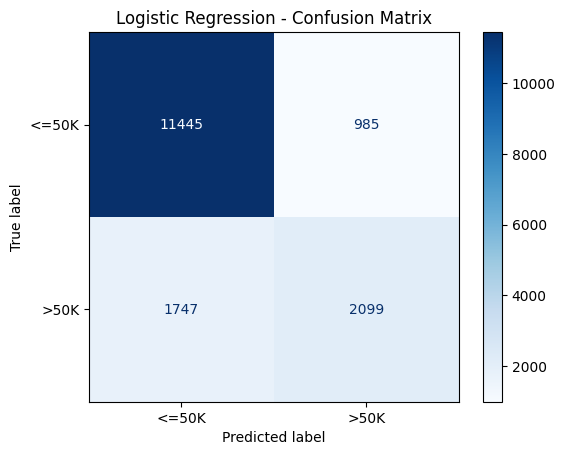

In [ ]:
logreg_results, logreg_y_test, logreg_y_prob = evaluate_model(logreg_search, model_Xtrain, model_Ytrain, model_Xtest, model_Ytest, "Logistic Regression")

### Evaluating the performance of the Random Forest Classifier


🔍 Random Forest Classifier Hyperparameter Tuning Results:
Best Parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': None}
Best CV Score:  0.6309

 Random Forest Classifier Model Evaluation:
              precision    recall  f1-score   support

       <=50K       0.87      0.92      0.90     12430
        >50K       0.69      0.56      0.62      3846

    accuracy                           0.84     16276
   macro avg       0.78      0.74      0.76     16276
weighted avg       0.83      0.84      0.83     16276

Accuracy: 0.8364
Precision: 0.6893
Recall: 0.5601
F1 Score: 0.6180
Training Time: 564.1539
Prediction Time: 0.8440


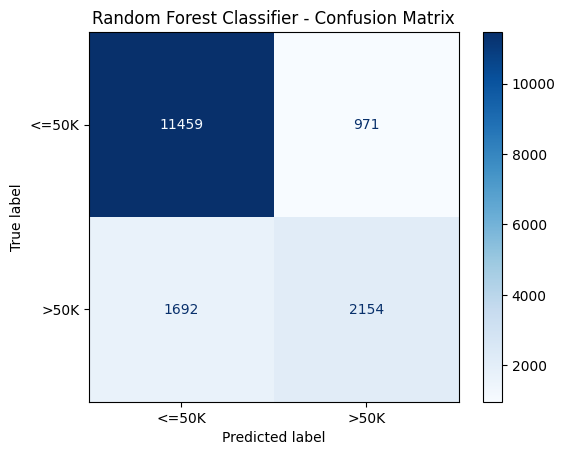

In [ ]:
rf_results, rf_y_test, rf_y_prob = evaluate_model(rf_search, model_Xtrain, model_Ytrain, model_Xtest, model_Ytest, "Random Forest Classifier")

### Model evaluation through ROC and Precision-Recall plots

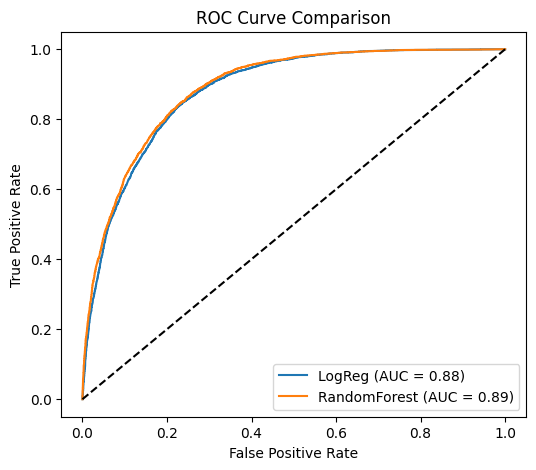

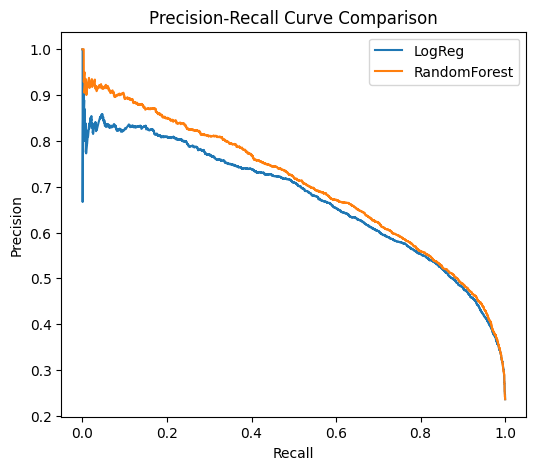

In [43]:
# Plot ROC Curve
plt.figure(figsize=(6, 5))

logreg_fpr, logreg_tpr, _ = roc_curve(logreg_y_test, logreg_y_prob, pos_label=">50K")
logreg_roc_auc = auc(logreg_fpr, logreg_tpr)
plt.plot(logreg_fpr, logreg_tpr, label=f"LogReg (AUC = {logreg_roc_auc:.2f})")

rf_fpr, rf_tpr, _ = roc_curve(rf_y_test, rf_y_prob, pos_label=">50K")
rf_roc_auc = auc(rf_fpr, rf_tpr)
plt.plot(rf_fpr, rf_tpr, label=f"RandomForest (AUC = {rf_roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(6, 5))

logreg_prec, logreg_rec, _ = precision_recall_curve(logreg_y_test, logreg_y_prob, pos_label=">50K")
plt.plot(logreg_rec, logreg_prec, label="LogReg")

rf_prec, rf_rec, _ = precision_recall_curve(rf_y_test, rf_y_prob, pos_label=">50K")
plt.plot(rf_rec, rf_prec, label="RandomForest")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.show()

## Conclusion

Both Logistic Regression and Random Forest have performed similarly well. Observations on the Precision-Recall curve have proven that Random Forest is slightly better at identifying instances of “>50K”, which is the minority class. 